In [1]:
import cosmopower as cp
import frb_cov as frb
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as units
import numpy as np
from astropy.coordinates import Longitude, Latitude
import matplotlib.pyplot as plt


2024-03-21 11:55:44.041359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load Emulators

In [2]:
bias_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/bias_sq_model")
power_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/pkmm_nonlin_model")


Define fiducial cosmology and initialise cosmo dictionary


In [3]:
sigma8 = 0.834
h = 0.674
omegam = 0.3
omegab = 0.05
omegade = 1.0 - omegam
w0 = -1
wa = 0
ns = 0.963
neff = 3.046
mnu = 0
Tcmb0 = 2.725
alpha_B = 0.5
alpha_M = 0.5
log_TAGN = 7.8
ks = 0.1
keys = ['sigma_8', 'h', 'omega_m', 'omega_b', 'omega_de', 'w0', 'wa',
        'ns', 'neff', 'm_nu', 'Tcmb0', 'alpha_B', 'alpha_M', 'logTAGN', 'ks']
values = [sigma8, h, omegam, omegab, omegade,
          w0, wa,  ns, neff, mnu, Tcmb0, alpha_B, alpha_M, log_TAGN, ks]
cosmo = dict(zip(keys, values))

Prepare FRB SAMPLE

In [4]:
frb_cat = ascii.read("./../data/catalogue_updated.csv", data_start=1)
ra = coord.Angle(frb_cat["ra (deg)"], unit=units.degree)
dec = coord.Angle(frb_cat["dec (deg)"], unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian

counts = len(frb_cat["redshift"])
n_with_host = counts
zet = frb_cat["redshift"][:n_with_host]
z = np.zeros(n_with_host)
DM_obs = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
    sep = '&'
    DM_obs[i] = frb_cat["dm"][i]
ra = ra[:n_with_host]
dec = dec[:n_with_host]

delta_theta = np.zeros((n_with_host, n_with_host))
for i in range(n_with_host):
    for j in range(n_with_host):
        if (i != j):
            delta_theta[i, j] = np.arccos(np.sin(
                ra[i])*np.sin(ra[j]) + np.cos(ra[i])*np.cos(ra[j])*np.cos(dec[i] - dec[j]))


In [5]:
cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,300)

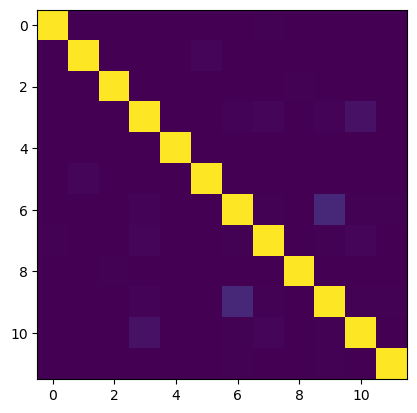

In [9]:
cov.get_covariance_flat_sky()
corr = cov.covariance/(np.diag(cov.covariance)[:, None]*np.diag(cov.covariance)[None, :])**.5
plt.imshow(corr)
